In [ ]:
# dirs for datasets files
!mkdir -p data/train2017 data/train2017/annotations
!mkdir -p data/validation2017_for_fine-tune

# utility for more fast and stable downloading
!sudo apt install axel

#3) download files via axel(3 files - train2017.zip, val2017.zip, annotations_trainval2017.zip):
!axel -o data/train2017/train2017.zip http://images.cocodataset.org/zips/train2017.zip
!axel -o data/validation2017_for_fine-tune/val2017.zip http://images.cocodataset.org/zips/val2017.zip
!axel -o data/validation2017_for_fine-tune/annotations_trainval2017.zip http://images.cocodataset.org/annotations/annotations_trainval2017.zip

#4) unzip files with respect to their dirs:
!unzip -q data/train2017/train2017.zip -d data/train2017
!unzip -q data/validation2017_for_fine-tune/val2017.zip -d data/validation2017_for_fine-tune
!unzip -q data/validation2017_for_fine-tune/annotations_trainval2017.zip -d data/validation2017_for_fine-tune

#5) rename unziped data/train2017/train2017 dir -> to data/train2017/images,
#rename unziped data/validation2017_for_fine-tune/val2017 dir -> data/validation2017_for_fine-tune/images:
!mv data/train2017/train2017 data/train2017/images
!mv data/validation2017_for_fine-tune/val2017 data/validation2017_for_fine-tune/images

#6) move train2017 annotation files from validation2017 annotation dir
# to train2017 annotations dir:
!mv data/validation2017_for_fine-tune/annotations/*train2017.json data/train2017/annotations

In [ ]:
!pip3 install virtualenv
!virtualenv datasets_for_SD_model
!source datasets_for_SD_model/bin/activate
!pip install numpy==1.26
!pip install scikit-image
!pip install matplotlib

In [ ]:
!pip install --upgrade setuptools wheel

In [ ]:
!pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI

  Cloning https://github.com/philferriere/cocoapi.git to /tmp/pip-req-build-6h2vyl9o
  Running command git clone --filter=blob:none --quiet https://github.com/philferriere/cocoapi.git /tmp/pip-req-build-6h2vyl9o
  Resolved https://github.com/philferriere/cocoapi.git to commit 2929bd2ef6b451054755dfd7ceb09278f935f7ad
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp311-cp311-linux_x86_64.whl size=398939 sha256=5cd09ffa85051959b41a0121adb11adf9f8cbc1bc2a4d6ea72c4786329e7d397
  Stored in directory: /tmp/pip-ephem-wheel-cache-xdwuwr3v/wheels/48/26/68/d7169b79632db4cf9ce71d33befbf0d89ae8b2d4d445ee8574
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.9
    Uninstalling pycocotools-2.0.9:
      Successfully uninstalled pycocotools-2.0.9


**Create Train, Validation COCO datasets files**

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import re

class Images_Annotations_File_Creation_For_Images_Dataset:
    def __init__(self, dataset_dir: str,
        images_annotation_file: str, images_description_annot_file: str):
        self.dataDir = 'data'
        self.dataset_dir = dataset_dir
        self.images_dir = f'{self.dataDir}/{self.dataset_dir}/images'
        self.images_annotation_file = f'{self.dataDir}/{self.dataset_dir}/annotations/{images_annotation_file}'
        self.images_description_annot_file = f'{self.dataDir}/{self.dataset_dir}/annotations/{images_description_annot_file}'
        self.validation_data_dir_regex = re.compile(r'.*validation.*')
        self.validation_samples_amount = 200

        self.images_cocoAPI = COCO(self.images_annotation_file)
        self.annotations_cocoAPI = COCO(self.images_description_annot_file)

        self.categories_IDs = self.images_cocoAPI.getCatIds()
        self.categories_info = self.images_cocoAPI.loadCats(self.categories_IDs)

        self.images_IDs_by_categories_IDs = self.images_cocoAPI.catToImgs
        self.images_amount_per_categories_IDs = {}
        self.images_IDs = self.get_all_unique_images_IDs()

        self.images_dataset_metadata = pd.DataFrame()
        self.images_dataset_JSON_metadata = []

    def get_all_unique_images_IDs(self):
        unique_images_IDs = self.images_IDs_by_categories_IDs[1]
        for category_ID in self.images_IDs_by_categories_IDs:
            unique_images_IDs = (
                np.union1d(
                    unique_images_IDs,
                    self.images_IDs_by_categories_IDs[category_ID]
                )
            )
        if re.match(self.validation_data_dir_regex, self.dataset_dir):
            if len(unique_images_IDs) > self.validation_samples_amount:
                return unique_images_IDs[:self.validation_samples_amount]
            return unique_images_IDs
        else:
            return unique_images_IDs

    def main(self):
        self.define_images_amount_per_categories_IDs()
        self.define_anomaly_big_imgs_categories()

        self.add_image_ID_column_to_dataset()
        self.add_image_filename_column_to_dataset()
        self.add_image_annotations_column_to_dataset()
        self.remove_image_ID_column()

        self.convert_dataset_into_JSON_format()
        self.create_JSONL_images_metadata_file()

    def define_images_amount_per_categories_IDs(self):
        for category_ID in self.images_IDs_by_categories_IDs:
            self.images_amount_per_categories_IDs[category_ID] = len(
                self.images_IDs_by_categories_IDs[category_ID]
            )
        return True

    def get_category_name_by_ID(self, categ_ID: int):
        return self.images_cocoAPI.loadCats([categ_ID])[0]['name']

    def add_image_ID_column_to_dataset(self):
        self.images_dataset_metadata['image_ID'] = self.images_IDs

    def add_image_filename_column_to_dataset(self):
        self.images_dataset_metadata["image"] = \
        self.images_dataset_metadata['image_ID'].apply(
            self.get_image_filename_path
        )

    def add_image_annotations_column_to_dataset(self):
        self.images_dataset_metadata["image_annotations"] = \
        self.images_dataset_metadata['image_ID'].apply(
            self.get_img_annotations
        )

    def get_image_filename_path(self, img_id: int):
        image_info = self.get_image_info_by_ID(img_id)
        return f"{self.images_dir}/{image_info['file_name']}"

    def get_img_annotations(self, img_id: int):
        image_annotation_IDs = self.get_image_annotation_IDs(img_id)
        image_annotations = self.get_image_annotations_by_IDs(image_annotation_IDs)
        return image_annotations

    def get_image_info_by_ID(self, img_id: int):
        return self.images_cocoAPI.loadImgs([img_id])[0]

    def get_image_annotation_IDs(self, img_id: int):
        return self.annotations_cocoAPI.getAnnIds(imgIds = [img_id])

    def get_image_annotations_by_IDs(self, annotations_IDs: list):
        image_annotations = []
        for annotation_info in self.annotations_cocoAPI.loadAnns(annotations_IDs):
            image_annotations.append(annotation_info['caption'])
        return image_annotations

    def remove_image_ID_column(self):
        self.images_dataset_metadata.drop(
            'image_ID',
            axis = 1,
            inplace = True
        )

    def convert_dataset_into_JSON_format(self):
        self.images_dataset_JSON_metadata = self.images_dataset_metadata.to_json(
            orient = 'records', lines = True
        )

    def create_JSONL_images_metadata_file(self):
        with open(f'{self.images_dir}/metadata.jsonl', 'w') as imgs_metadata:
            imgs_metadata.write(self.images_dataset_JSON_metadata)


In [ ]:
# Create train, validation dataset JSONL files for SD fune-tuning script:
datasets_info = {
    "TRAIN": [
        'train2017',
        'instances_train2017.json',
        'captions_train2017.json'
    ],
    "VALIDATION": [
        'validation2017_for_fine-tune',
        'instances_val2017.json',
        'captions_val2017.json'
    ]
}

def create_images_metadata_datasets(datasets_info: dict):
    for dataset_type in datasets_info:
        ds_creation = Images_Annotations_File_Creation_For_Images_Dataset(
            datasets_info[dataset_type][0],
            datasets_info[dataset_type][1],
            datasets_info[dataset_type][2],
        )
        ds_creation.main()

if __name__ == '__main__':
    create_images_metadata_datasets(datasets_info)

**Install diffusers lib, setup accelerate env + install additional libs**

In [ ]:
# Installing accelerate lib for executing train model script
!git clone https://github.com/huggingface/diffusers
!pip install diffusers/
!pip install -r diffusers/examples/text_to_image/requirements.txt
#Init Accelerate environment
!accelerate config default
# make a dir for result fine-tuned SD model
!mkdir finetuned_S_D_LoRA_model

In [ ]:
!pip install peft==0.15

In [ ]:
!pip install torch==2.7.0+cu126 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

In [ ]:
!pip install --force-reinstall --no-deps --pre xformers

**SD model Fine-Tuning:**

In [ ]:
# dir for result train, validation losses files for further analyzing.
!mkdir result_losses

In [ ]:
# Now, upload fine-tune_SD_LoRA_model_with_validation.py to this notebook and
# this cmd will move to necessary place.
!mv /content/fine-tune_SD_LoRA_model_with_validation.py diffusers/examples/text_to_image/

In [ ]:
# fine-tune SD model
!export HF_ENDPOINT=https://hf-mirror.com

!accelerate launch diffusers/examples/text_to_image/fine-tune_SD_LoRA_model_with_validation.py \
  --pretrained_model_name_or_path="stable-diffusion-v1-5/stable-diffusion-v1-5" \
  --snr_gamma=5.0 \
  --dataset_name="data" \
  --resolution=512 --center_crop --random_flip \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --max_train_samples=1000 \
  --train_batch_size=20 \
  --total_train_epochs=100 \
  --learning_rate=1e-04 \
  --max_grad_norm=5 \
  --enable_xformers_memory_efficient_attention \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --validation_prompt="Black Lamborghini at midnight city." \
  --val_batch_size=20 \
  --validation_epochs=1 \
  --report_to="tensorboard" \
  --output_dir="finetuned_S_D_LoRA_model"

**Train and Validation Epochs Losses analyzing:**

In [ ]:
!pip install PyQt5

In [ ]:
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib
matplotlib.use("qt5agg")
import matplotlib.pyplot as plt

train_loss_df = pd.read_csv("Final_Train_Epochs_losses.csv")
validation_loss_df = pd.read_csv("Final_Validation_Epochs_losses.csv")

def get_approximated_X_Y(polynom_coeffs: list, points_amount: int):
    approximated_X_Y = {}
    approximated_X_Y['epoch'] = get_X(points_amount)
    approximated_X_Y['loss'] = get_Y(polynom_coeffs, points_amount)
    return approximated_X_Y

def get_polynomial_coefficients_for_approximation(x_data, y_data):
    return polyfit(x_data, y_data, 3)

def get_X(points_amount = 100):
    max_x = points_amount
    return np.linspace(1, max_x, points_amount)

def get_Y(polynom_coeffs: list, points_amount = 100):
    Y = []
    for x in range(1, points_amount + 1):
        Y.append(get_polynomial_y_value(polynom_coeffs, x))
    return Y

def get_polynomial_y_value(polynom_coeffs: list, x_value: int):
    result_y = 0
    for i in range(len(polynom_coeffs)):
        result_y += polynom_coeffs[i] * x_value ** i
    return result_y

def show_train_validation_plots(original_train_loss_data: pd.DataFrame, original_validation_loss_data: pd.DataFrame,
approx_train_loss_data: dict, approx_validation_loss_data: dict):
    plt.title("Train vs Validation Loss + Approximation Lines")
    plt.plot(original_train_loss_data["epoch"], original_train_loss_data["loss"], '.r-', label = "train-loss")
    plt.plot(original_validation_loss_data["epoch"], original_validation_loss_data["loss"], '.g-', label = 'validation-loss')
    plt.plot(approx_train_loss_data["epoch"], approx_train_loss_data["loss"], 'r-', label = "train-loss(approximated)")
    plt.plot(approx_validation_loss_data["epoch"], approx_validation_loss_data["loss"], 'g-', label = 'validation-loss(approximated)')
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    plt.show()

if __name__ == '__main__':
    polynom_train_coeffs = get_polynomial_coefficients_for_approximation(train_loss_df['epoch'], train_loss_df['loss'])
    polynom_validation_coeffs = get_polynomial_coefficients_for_approximation(validation_loss_df['epoch'], validation_loss_df['loss'])
    approximated_train_loss_data = get_approximated_X_Y(polynom_train_coeffs, 140)
    approximated_validation_loss_data = get_approximated_X_Y(polynom_validation_coeffs, 140)
    show_train_validation_plots(
        train_loss_df, validation_loss_df,
        approximated_train_loss_data, approximated_validation_loss_data,
    )


In [ ]:
# in case if you want to retrain model again.
!rm -r finetuned_S_D_LoRA_model/*

**Test Fine-tuned SD model**

In [ ]:
from diffusers import DiffusionPipeline
import torch

In [ ]:
model_path = "finetuned_S_D_LoRA_model"
pipeline = DiffusionPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16,
    safety_checker = None
)
pipeline.to("cuda")
pipeline.load_lora_weights(model_path)

  0%|          | 0/50 [00:00<?, ?it/s]

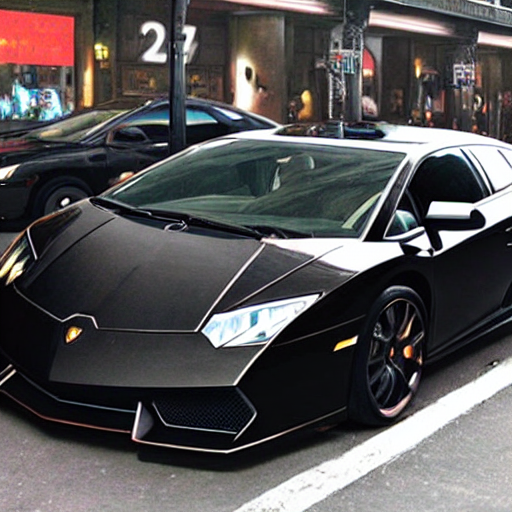

In [ ]:
prompt = "Black Lamborghini at midnight city."
PIL_image = pipeline(prompt).images[0]
PIL_image